## Realistic Example -England, Wales, Scotland Local authority district states from ONS death data

In this notebook we load the ons data coronavirus deaths for England, Wales and Scotland and infer the trajectory using Pyross inference with lit values for a simple SEAIMR model. First we load all the things that will be neccessary.

In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [2]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import pyross
import time 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#from matplotlib import rc; rc('text', usetex=True)

Then we set parameters and load data. In age rates we load the mean values of alpha, mm, cc and hh for all the LADs (local authority districts) that we are interested in. In resident_data_2018 are the populations of the LADsin the age groups from 2018 that pyrosGeo uses and in death table the ons recorded deaths in a readable format. We load the population into resident_data_20182_raw and shape it into the form we require with 7 age groups. We also load the contact matrix of the UK and use it on a local level. One major problem here is the fact that we are not yet accounting for cross LAD contamination.

In [3]:
death_table = pd.read_csv('UK Inference Data/out.csv', sep=',').transpose().drop('Unnamed: 0')
death_table=death_table.reset_index()
death_table=death_table.rename(columns={'index':'Name'})
#deaths are accumulated
cumulativedeaths=death_table
for i in range(1,16):
    cumulativedeaths[i]=cumulativedeaths[i-1]+cumulativedeaths[i]

AgeRates = pd.read_csv('UK Inference Data/AgeRate.csv')
AgeRates=AgeRates.rename(columns={'AreaCode':'Name'})
AgeRates=AgeRates.drop(columns=["Unnamed: 0"])


#population data is loaded

resident_data_20182_raw = pd.read_excel('UK Inference Data/ukmidyearestimates20182019ladcodes.xls', 'MYE2-All', skiprows=4)
resident_data_20182_raw=resident_data_20182_raw.drop(columns=['Geography1',"Name"])
resident_data_20182_raw=resident_data_20182_raw.rename(columns={90:'90+'})
resident_data_20182_raw=resident_data_20182_raw.rename(columns={'Code':'AreaCode','All ages':'All Ages'})
resident_data_20182_raw =resident_data_20182_raw[resident_data_20182_raw['AreaCode'].isin(death_table.Name)]
resident_data_2018_raw=resident_data_20182_raw


    
# # We need to age-group the data to match the census workplace data
resident_data_2018 = resident_data_2018_raw[['AreaCode', 'All Ages']]
age_groups = [16, 25, 35, 50, 65, 75]
i = 0
for i_end in age_groups:
    label = '{}-'.format(i)
    age_sum = resident_data_2018_raw[i].copy()
    i += 1
    while i < i_end:
        age_sum += resident_data_2018_raw[i]
        i += 1

    label = label + '{}'.format(i-1)
    resident_data_2018[label] = age_sum

age_sum = resident_data_2018_raw[i].copy()
i += 1
while i < 90:
    age_sum += resident_data_2018_raw[i]
    i += 1
age_sum += resident_data_2018_raw['90+']
resident_data_2018['75+'] = age_sum
resident_data_2018=resident_data_2018.rename(columns={'AreaCode':'Name'})
resident_data_2018=resident_data_2018.reset_index(drop=True)
resident_data_2018=resident_data_2018.merge(cumulativedeaths, on='Name', how='right')
AgeRates=AgeRates.merge(cumulativedeaths, on='Name')

M  = 7              # the population has 7 age groups     
# correct params in 1/week, beta is just guessed
beta  = 3               # infection rate
gE    = 1/2.72*7        # exposed to activated rate
gA    = 1/3.12*7        # activated to infected rate
gIa   = 1./7*7        # recovery rate of asymptomatic infectives
gIs   = 1./17.76*7       # To hospital
   # fsa   = 1         # the self-isolation parameter (assumed to be known but really isn't) and so I am not using it here

alpha = np.array([0.56762858, 0.44317647, 0.36356883, 0.28385665, 0.21301662, 0.16467453,
 0.1350941 ])
cfr=np.array([2.39486049e-05, 7.78602514e-04, 3.28379737e-03, 1.13063420e-02,  3.20517124e-02, 6.64601638e-02, 1.06760828e-01])
hh= np.array([0.05004547, 0.11524135, 0.16268827, 0.21877324, 0.28080714, 0.33441327, 0.37462764])
cc= np.array([0.09504815, 0.19134113, 0.25551887, 0.32758932, 0.40389807, 0.46764803, 0.51438423])
mm= np.array([0.02029352, 0.08723728, 0.15941184, 0.26756575, 0.4139815,  0.56187667, 0.68527581])
sus= np.array([0.2, 0.5, 0.7, 0.8, 1,  1, 1])

#Here we load the contact matrix

CH0, CW0, CS0, CO0 =pyross.contactMatrix.UK()

CH = np.zeros((M, M))
CW = np.zeros((M, M))
CS = np.zeros((M, M))
CO = np.zeros((M, M))
z=[3,2,2,3,3,2,1]
i1, j1 =0, 0
for l in range(M):
    j1=0
    for j in range(M):
        CH[l,j] = np.sum( CH0[i1:i1+z[l], j1:j1+z[l]] )
        CW[l,j] = np.sum( CW0[i1:i1+z[l], j1:j1+z[l]] )
        CS[l,j] = np.sum( CS0[i1:i1+z[l], j1:j1+z[l]] )
        CO[l,j] = np.sum( CO0[i1:i1+z[l], j1:j1+z[l]] )
        j1 = j1+z[j]
    i1 = i1+z[l] 
C = CO+CS+CH+CW    
A=np.sum(C)
C=C/A

#We define the model in here in the vein of Spp.



model_spec = {
    "classes" : ["S", "E", "A", "Ia", "Is", "Im"],

    "S" : {
        "linear"    : [],
        "infection" : [ ["A", "-betaEffec"], ["Ia", "-betaEffec"], ["Is", "-betaEffec"] ]
    },

    "E" : {
        "linear"    : [ ["E", "-gammaE"] ],
        "infection" : [ ["A", "betaEffec"], ["Ia", "betaEffec"], ["Is", "betaEffec"] ]
    },
    
    "A" : {
        "linear"    : [ ["E", "gammaE"], ["A", "-alphabar*gammaA"], ["A", "-alpha*gammaA"] ],
        "infection" : [ ]
    },

    "Ia" : {
        "linear"    : [ ["A", "alpha*gammaA"], ["Ia", "-gammaIa"] ],
        "infection" : [ ]
    },
    
    "Is" : {
        "linear"    : [ ["A", "alphabar*gammaA"], ["Is", "-cfrbar*gammaIs"], ["Is", "-cfr*gammaIs"] ],
        "infection" : [ ]
    },
    
    "Im" : {
        "linear"    : [ ["Is", "cfr*gammaIs"] ],
        "infection" : [ ]
    }
}
M=7

    
def contactMatrix(t):
    return C


avAlpha=AgeRates['Asymp'][i]
avCFR=AgeRates['HH'][i]*AgeRates['CC'][i]*AgeRates['MM'][i]


/home/jakub/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/jakub/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Then we guess some initial conditions and run the optimisation over the LADS. Note that to ensure the functionaility of the code we run it whenever we push it to git so I have commented out things that take long.

In [6]:
T1 = 12 
T2 = 16
Sf=np.zeros((len(resident_data_2018),M,T2-T1))
Ef=np.zeros((len(resident_data_2018),M,T2-T1))
Af=np.zeros((len(resident_data_2018),M,T2-T1))
Iaf=np.zeros((len(resident_data_2018),M,T2-T1))
Isf=np.zeros((len(resident_data_2018),M,T2-T1))
Rf=np.zeros((len(resident_data_2018),M,T2-T1))
steps=20
    
# Get individual contact matrices


bound1=int(len(resident_data_2018)/5)
bound2=int(len(resident_data_2018)/5*2)
bound3=int(len(resident_data_2018)/5*3)
bound4=int(len(resident_data_2018)/5*4)

#test
for i in range(0,1):

#this runs it continuously, it is now quite quick
# for i in range(0,len(resident_data_2018)):

#This is here for our own use since we ran it on 5 computers
#1
# for i in range(342,343):
#2
# for i in range(bound1,bound2):
#3
# for i in range(bound2,bound3):
#4
# for i in range(bound3,bound4):
#5
# for i in range(bound4,len(resident_data_2018)):


    #Load the population of the specific LAD
    Ni=np.zeros((M))
    k=resident_data_2018[resident_data_2018['Name']==cumulativedeaths['Name'][i]].index.values[0]
    Ni[0] = resident_data_2018['0-15'][k].astype('int')
    Ni[1] = resident_data_2018['16-24'][k].astype('int')
    Ni[2] = resident_data_2018['25-34'][k].astype('int')
    Ni[3] = resident_data_2018['35-49'][k].astype('int')
    Ni[4] = resident_data_2018['50-64'][k].astype('int')
    Ni[5] = resident_data_2018['65-74'][k].astype('int')
    Ni[6] = resident_data_2018['75+'][k].astype('int')

    N = np.sum(Ni)
    fi = Ni/N 
    #you must load the model anew every single time for differing fi's which is an issue that is being looked at
    k=resident_data_2018[AgeRates['Name']==cumulativedeaths['Name'][i]].index.values[0]
    avAlpha=AgeRates['Asymp'][k]
    avCFR=AgeRates['HH'][k]*AgeRates['CC'][k]*AgeRates['MM'][k]
    avhh=AgeRates['HH'][k]
    avcc=AgeRates['CC'][k]
    avmm=AgeRates['MM'][k]
    
    cumulativedeathsArr=cumulativedeaths.iloc[i].values
    weeklyDeathsArr=death_table.iloc[i].values
    weeklyDeathsArr = np.array(weeklyDeathsArr[T1:T2], dtype='float')
    cumulativedeathsArr = np.array(cumulativedeathsArr[T1:T2], dtype='float')
    if(cumulativedeathsArr[len(cumulativedeathsArr)-1]>1):
        recov=weeklyDeathsArr/avCFR
        icu=weeklyDeathsArr/avmm
        hospital=icu/avcc
        symptomatic=hospital/avhh
        asymptomatic=symptomatic*avAlpha/(1-avAlpha)    
        activated=symptomatic/(1-avAlpha)

        #These are here to split the up the asymptomatic/infected/others in the ways predicted by alpha and other parameters
        InCfr=1-cfr
        totSus=0
        for j in range(0, M):
            totSus=sus[j]*Ni[j]+totSus
        totAlpha=0
        for j in range(0, M):
            totAlpha=sus[j]*(alpha[j])*Ni[j]+totAlpha
        totInalpha=0
        for j in range(0, M):
            totInalpha=sus[j]*(1-alpha[j])*Ni[j]+totInalpha
#         totInalphaHH=0
#         for j in range(0, M):
#             totInalphaHH=sus[j]*hh[j]*alpha[j]*Ni[j]+totInalphaHH
#         totInalphaCC=0
#         for j in range(0, M):
#             totInalphaCC=sus[j]*cc[j]*hh[j]*alpha[j]*Ni[j]+totInalphaCC
        totInalphaMM=0
        for j in range(0, M):
            totInalphaMM=sus[j]*mm[j]*cc[j]*hh[j]*(1-alpha[j])*Ni[j]+totInalphaMM

        cumulativedeathsArrDivdM=np.zeros((M,len(weeklyDeathsArr)))
        for j in range(0,M):
            cumulativedeathsArrDivdM[j]=cumulativedeathsArr*sus[j]*mm[j]*cc[j]*hh[j]*(1-alpha[j])*Ni[j]/totInalphaMM

        # set up initial condition, ideally you want nonzero values everywhere otherwise the optimiser can be rather unhappy for some reason.
        if(activated[1]>0):
            E0   = activated[3]*sus*Ni/totSus/20
            A0   = activated[3]*sus*Ni/totSus/30
            Ia0  = asymptomatic[2]*sus*Ni*(alpha)/totAlpha/15 
            Is0  = (symptomatic[1]+symptomatic[2])/2*sus*Ni*(1-alpha)/totInalpha/15
            R0   = symptomatic[0]*(1-avCFR)*Ni*sus*(alpha)/totAlpha+ (asymptomatic[0]+asymptomatic[1])*sus*Ni*(1-alpha)/totInalpha
            S0   = Ni - (E0 + A0 + Ia0 + Is0  + cumulativedeathsArrDivdM.transpose()[0] + R0)
        else:
            E0   = (activated[3]+9)*sus*Ni/totSus/20
            A0   = (activated[3]+9)*sus*Ni/totSus/20
            Ia0  = (asymptomatic[2]+3)*sus*Ni*(alpha)/totAlpha/10 
            Is0  = (symptomatic[1]+symptomatic[2]+3)*sus*Ni*(1-alpha)/totInalpha/10
            R0   = symptomatic[0]*(1-avCFR)*Ni*(alpha)/totAlpha+ (asymptomatic[0]+asymptomatic[1])*Ni*(1-alpha)/totInalpha+3
            S0   = Ni - (E0 + A0 + Ia0 + Is0 + cumulativedeathsArrDivdM.transpose()[0] + R0)

    #This is your observed quantity
        obs=cumulativedeathsArrDivdM
        obs=obs.transpose()
        obs=obs/N

    #Now we look at the bounds for all the categories that we did not observe
#         beta_g = 1
#         beta_std = beta_g*0.5
#         beta_bounds = (beta_g*0.1, beta_g*3)
        #float
#         beta_g=(5+((cumulativedeathsArr[3]+1)/(cumulativedeathsArr[2]+1)+(cumulativedeathsArr[2]+1)/(cumulativedeathsArr[1]+1)+(cumulativedeathsArr[1]+1)/(cumulativedeathsArr[0]+1))/3)
        beta_std = 0.5
        #array
        beta_g =sus*(5+((cumulativedeathsArr[3]+1)/(cumulativedeathsArr[2]+1)+(cumulativedeathsArr[2]+1)/(cumulativedeathsArr[1]+1)+(cumulativedeathsArr[1]+1)/(cumulativedeathsArr[0]+1))/3)

        beta_bounds = (0.1, 10)
        #We want to be bounded at least by 1 person in every class, otherwise it can have problems and go negative
        BoundsArray=np.ones(M)/100
        if(E0[0]>10):
            E0_g = (E0)/N
        else:
            E0_g=np.array([30/N]*M)
        E_std = E0_g*0.5 
        if(E0_g[0]>10/N):
            bounds_for_E = np.array([E0_g/3,E0_g*4/3+Ni/N/35]).transpose()
        else:
            bounds_for_E = np.array([BoundsArray/N,Ni/20/N]).transpose()

        if(A0[0]>10):
            A0_g = (A0)/N
        else:
            A0_g=np.array([20/N]*M)
        A_std = A0_g*0.5
        if(A0_g[0]>10/N):
            bounds_for_A = np.array([A0_g/3,A0_g*4/3+Ni/N/35]).transpose()
        else:
            bounds_for_A = np.array([BoundsArray/N,Ni/20/N]).transpose()

        if(Ia0[0]>10):
            Ia0_g = (Ia0)/N
        else:
            Ia0_g=np.array([5/N]*M)
        Ia_std = Ia0_g*0.5
        if(Ia0_g[0]>10/N):
            bounds_for_Ia = np.array([Ia0_g/3,Ia0_g*4/3+Ni/N/35]).transpose()
        else:
            bounds_for_Ia = np.array([BoundsArray/N,Ni/20/N]).transpose()

        if(Is0[0]>10):
            Is0_g = (Is0)/N
        else:
            Is0_g=np.array([5/N]*M)
        Is_std = Is0_g*0.5
        if(Is0_g[0]>10/N):
            bounds_for_Is = np.array([Is0_g/3,Is0_g*4/3+Ni/N/35]).transpose()
        else:
            bounds_for_Is = np.array([BoundsArray/N,Ni/20/N]).transpose()

        S0_g = (S0)/N
        if(np.all(S0-Ni<-0.01-10/N)):
            S_std = S0_g*0.01+10/N
        else:
            S_std = Ni-S0/N
        bounds_for_S = np.array([0.9*S0_g,Ni/N]).transpose()

         #For simulation
#         x0=np.array([S0_g, E0_g, A0_g, Ia0_g, Is0_g, (cumulativedeathsArrDivdM.transpose()[0])/N])
        #For inference
    #     x0=np.array([S0_g, E0_g, A0_g, Ia0_g, Is0_g])
#         x0=x0.flatten()

        # optimisation parameters 
        ftol = 1e-5 # the relative tol in (-logp)  

        fltr=np.kron(([0, 0, 0, 0, 0, 1]), np.identity(M))
        parameters ={
            'betaEffec' : sus*(5+((cumulativedeathsArr[3]+1)/(cumulativedeathsArr[2]+1)+(cumulativedeathsArr[2]+1)/(cumulativedeathsArr[1]+1)+(cumulativedeathsArr[1]+1)/(cumulativedeathsArr[0]+1))/3),
            'gammaE' : gE,
            'alpha*gammaA' : alpha*gA,
            'alphabar*gammaA' : (1 - alpha)*gA,
            'gammaIa' : gIa,
            'cfrbar*gammaIs': (1-cfr)*gIs,
            'cfr*gammaIs': (cfr)*gIs
        }

        # set up bounds, guess and stds for the rest of the params 
        bounds = np.array([beta_bounds, *bounds_for_S,  *bounds_for_E, *bounds_for_A, *bounds_for_Ia, *bounds_for_Is ])
        guess = np.array([beta_g,  *S0_g, *E0_g, *A0_g, *Ia0_g, *Is0_g])
        stds = np.array([beta_std, *S_std, *E_std, *A_std, *Ia_std, *Is_std])
        init_fltr = np.repeat([ True, True, True, True, True, False], M)
        param_keys = ['betaEffec']
        start_time = time.time()
    #uncomment to properly run optimisations, currently commented due to everything on pyross being run every time things are pushed and this takes a while to run
#         estimator = pyross.inference.Spp(model_spec, parameters, M, fi, int(N), T2-T1)
#         params = estimator.latent_infer_parameters(param_keys, init_fltr, guess, stds, obs, fltr,  T2-T1-1,  T2-T1, contactMatrix, bounds, global_max_iter=150, global_ftol_factor=1e3, verbose=True, ftol=ftol,local_max_iter=10, tangent=True, infer_scale_parameter=True)
#         partial_inits = params[len(param_keys):]
#         x0 = estimator.fill_initial_conditions(partial_inits, obs[0], init_fltr, fltr)
#         best_estimates = estimator.fill_params_dict(param_keys, params)
#         det_model = pyross.deterministic.Spp(model_spec, best_estimates, int(M), fi)
#         x_det = det_model.simulate(x0, contactMatrix, T2-T1-1, T2-T1)
#         data_array=x_det['X']
#         for j in range(0,M):
#             Sf[i][j]=data_array[:, j]/Ni[j]*N
#             Ef[i][j]=data_array[:, 1*M+j]/Ni[j]*N
#             Af[i][j]=data_array[:, 2*M+j]/Ni[j]*N
#             Iaf[i][j]=data_array[:, 3*M+j]/Ni[j]*N
#             Isf[i][j]=data_array[:, 4*M+j]/Ni[j]*N
#             Rf[i][j]=1-(data_array[:, 4*M+j]+np.array(data_array[:, 3*M+j])+np.array(data_array[:, 2*M+j])+np.array(data_array[:, 1*M+j])+np.array(data_array[:,j])+data_array[:, 5*M+j])/Ni[j]*N
#     else:
#         for j in range(0,M):
#             Sf[i][j]=np.ones(T2-T1)
#             Ef[i][j]=np.zeros(T2-T1)
#             Af[i][j]=np.zeros(T2-T1)
#             Iaf[i][j]=np.zeros(T2-T1)
#             Isf[i][j]=np.zeros(T2-T1)
#             Rf[i][j]=np.zeros(T2-T1)

np.save('SF', Sf)
np.save('EF',Ef)
np.save('AF',Af)
np.save('IaF',Iaf)
np.save('IsF',Isf)
np.save('Rf',Rf)


Starting global minimisation...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 36 (seed=2143991190, Mon May 25 14:05:17 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 5.773684042502524e+24 1.0e+00 9.38e-01  2e-05  5e-01 0:00.3
    2     32 3.691779108193448e+23 1.1e+00 9.15e-01  2e-05  5e-01 0:00.6
    3     48 1.400024537216005e+22 1.1e+00 9.02e-01  2e-05  5e-01 0:00.9
    4     64 -5.347039115189805e+02 1.1e+00 9.04e-01  2e-05  5e-01 0:01.2
Optimal value (global minimisation):  -534.7039115189805
Starting local minimisation...
Optimal value (local minimisation):  -534.7039115189716
Starting global minimisation...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 36 (seed=2824756157, Mon May 25 14:05:19 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 2.542410824320109e+12 1.0e+00 9.37e-01  2e-05  5e-01 0:00.4
    2     32 -4.754905113318302e+02 1.1e+00 8.95e-01  2e-05  4e-01 0:00.8
    3     48 -4.

In [11]:
for i in range(0, len(Sf)):
    if((Sf[i][0][0]>1) or (Sf[i][0][0]<0)):
        print(i)

To check any of the lads run it above and then run this

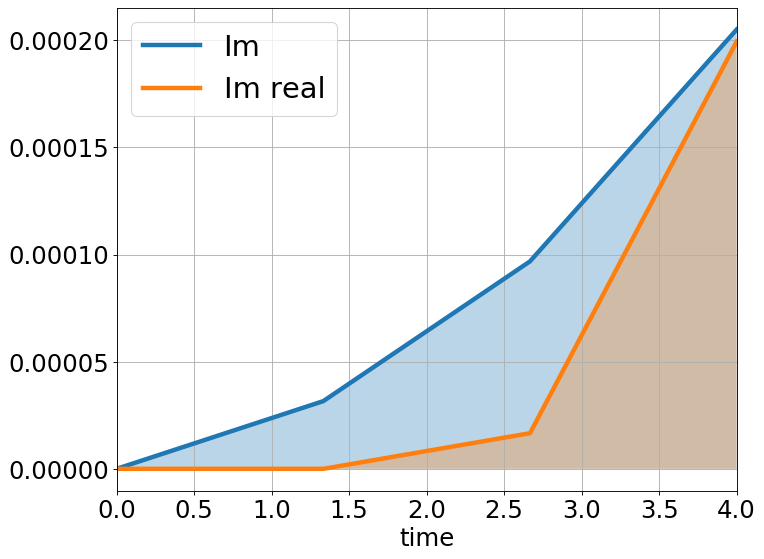

In [7]:
# # partial_inits = params[len(param_keys):]
# # x0 = estimator.fill_initial_conditions(partial_inits, obs[0], init_fltr, fltr)
# # best_estimates = estimator.fill_params_dict(param_keys, params)
# det_model = pyross.deterministic.Spp(model_spec, best_estimates, int(M), fi)
# x_det = det_model.simulate(x0, contactMatrix, T2-T1-1, T2-T1)

# data_array=x_det['X']
# fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
# plt.rcParams.update({'font.size': 22})
# t = np.linspace(0,len(cumulativedeathsArr),len(cumulativedeathsArr))

# # plt.fill_between(t, 0, np.sum(data_array[:, :M], axis=1),  alpha=0.3)
# # plt.plot(t, np.sum(data_array[:, :M], axis=1), '-', label='S', lw=4)

# # plt.fill_between(t, 0, np.sum(data_array[:, M:2*M], axis=1), alpha=0.3)
# # plt.plot(t, np.sum(data_array[:, M:2*M], axis=1), '-', label='E', lw=4)

# # plt.fill_between(t, 0, np.sum(data_array[:, 2*M:3*M], axis=1), alpha=0.3)
# # plt.plot(t, np.sum(data_array[:, 2*M:3*M], axis=1), '-', label='A', lw=4)

# # plt.fill_between(t, 0, np.sum(data_array[:, 3*M:4*M], axis=1), alpha=0.3)
# # plt.plot(t, np.sum(data_array[:, 3*M:4*M], axis=1), '-', label='Ia', lw=4)

# # plt.fill_between(t, 0, np.sum(data_array[:, 4*M:5*M], axis=1), alpha=0.3)
# # plt.plot(t, np.sum(data_array[:, 4*M:5*M], axis=1), '-', label='Is', lw=4)

# plt.fill_between(t, 0, np.sum(data_array[:, 5*M:6*M], axis=1), alpha=0.3)
# plt.plot(t, np.sum(data_array[:, 5*M:6*M], axis=1), '-', label='Im', lw=4)

# plt.fill_between(t, 0, cumulativedeathsArr/N, alpha=0.3)
# plt.plot(t, cumulativedeathsArr/N, '-', label='Im real', lw=4)



# plt.legend(fontsize=26)
# plt.grid() 
# plt.xlabel(r'time') 
# plt.autoscale(enable=True, axis='x', tight=True)
# plt.savefig("Showcase.png")